# 🎵 Music Genre Classification

This notebook presents a machine learning pipeline for classifying music genres using Support Vector Machines (SVM) with One-vs-Rest and One-vs-One strategies.

We use the GTZAN dataset and audio features (MFCC). The model used is RBF Binary Kernel SVM with both multiclass classification strategies One-vs-Rest and One-vs-One.


In [71]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import random
import sys
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import courselib.utils.loaders as loaders
from courselib.utils.splits import train_test_split
from sklearn.preprocessing import StandardScaler
from courselib.models.multiclass_svm import KernelMulticlassOvR
from courselib.models.multiclass_svm import KernelMulticlassOvO
from courselib.utils.metrics import confusion_matrix
from courselib.utils.preprocessing import labels_to_numbers
from courselib.utils.preprocessing import labels_encoding
from courselib.utils.preprocessing import one_hot_encoding
from courselib.models.nn import MLP
from courselib.optimizers import GDOptimizer
from courselib.optimizers import Optimizer
from courselib.optimizers import AdamOptimizer
from courselib.utils.metrics import accuracy
from courselib.utils.metrics import cross_entropy


# Add the repo root (two levels up from this notebook) to sys.path
sys.path.insert(0, os.path.abspath("../../"))

config = {
    "C": 1.0,
    "kernel": "rbf",
    "random_seed": 42,
    "training_data_fraction": 0.8,
    "layer_widths": [40, 128, 64, 10],
    "optimizer_learning_rate": 0.001,
    "activation": "ReLU",
    "output_activation": "Softmax",
    "loss": "CE",
    "epochs": 200,
    "batch_size": 128,
}

config_cnn = {
    "img_size": 128,
    "batch_size": 32,
    "data_path": "./data/spectrograms",
    "training_data_fraction": 0.8,
    "epochs": 20,
    "normalize_mean": [0.5, 0.5, 0.5],
    "normalize_std": [0.5, 0.5, 0.5],
    "learning_rate": 0.001,
    "dropout": 0.5,
    "num_classes": 10,
    "activation": "ReLU"
}

np.random.seed(config["random_seed"])
random.seed(config["random_seed"])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading
 
The GTZAN dataset has data in 2 formats:
1. 30s fragments of each song
2. Each fragment from 1. is split into 10 segments with 3s length

We will work with the 30s file.

In [72]:
df = loaders.load_music_30_sec()
#df = loaders.load_music_3_sec()

class_names = sorted(df["label"].unique().tolist())

Loading from `data/features_30_sec.csv`...


### Train-Test Split

We will train the models on all MFCC features and do the train-test split proportion 80/20.

In [73]:
# Extract only MFCC columns from df
mfcc_columns = [col for col in df.columns if col.startswith('mfcc')]
features = mfcc_columns + ['label']

# Do train test split
X, Y, X_train, Y_train, X_test, Y_test = train_test_split(
    df[features],
    training_data_fraction=config["training_data_fraction"],
    class_column_name='label',
    shuffle=True,
    return_numpy=True
)

print('Training data split as follows:')
print(f'  Training data samples: {len(X_train)}')
print(f'      Test data samples: {len(X_test)}')

Training data split as follows:
  Training data samples: 800
      Test data samples: 200


## Preprocessing

We standardize our features using z-score normalization. This step rescales all features to have zero mean and unit variance.

We also compute a reasonable value for the kernel width parameter $\sigma$ using the *median heuristic*:
$$
\sigma = \sqrt{ \frac{ \text{median}( \| x_i - x_j \|^2 ) }{2} }
$$

This tunning was done because of low accuracy on not preprocessed data.

In [74]:
# Standardize features (z-score)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

# Compute kernel width using median heuristic (for RBF kernel)
subset = X_train[np.random.choice(len(X_train), 500, replace=False)]
d2 = np.sum((subset[:, None, :] - subset[None, :, :])**2, axis=-1)
sigma = np.sqrt(0.5 * np.median(d2[d2 > 0]))  # avoid zero distances

### OvR model

First we train the OvR classification strategy with the RBF Binary Kernel SVM model.

Then evaluate the performance ovr the test data. Both single model as well as overall performance statistics are calculated.

In [75]:
svmOvR = KernelMulticlassOvR(kernel=config["kernel"], sigma=sigma, C=config["C"])
svmOvR.fit(X_train, Y_train)

🎯 Overall accuracy (OvR): 68.5000 %
📊 Accuracy of each binary model (One-vs-Rest):
  - Class 'blues': 91.0000
  - Class 'classical': 98.5000
  - Class 'country': 91.5000
  - Class 'disco': 91.0000
  - Class 'hiphop': 90.0000
  - Class 'jazz': 92.0000
  - Class 'metal': 97.5000
  - Class 'pop': 96.0000
  - Class 'reggae': 90.5000
  - Class 'rock': 94.5000


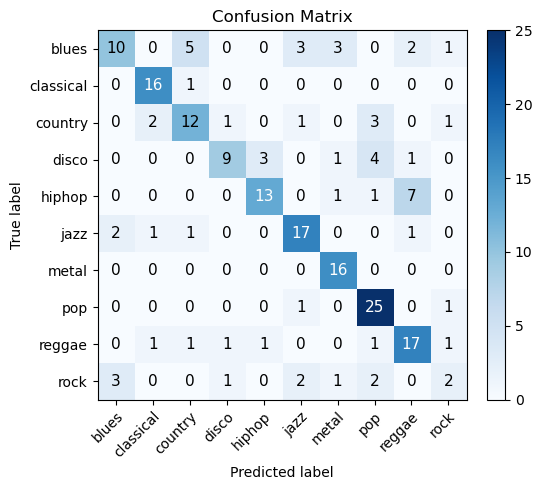

In [76]:
svmOvR.evaluate_accuracy(X_test, Y_test)
svmOvR.evaluate_models(X_test, Y_test)

true_labels = labels_encoding(Y_test, labels=class_names, pos_value=1, neg_value= 0)
pred_labels = labels_encoding(svmOvR(X_test), labels=class_names, pos_value=1, neg_value= 0)

confusion_matrix(true_labels, pred_labels, num_classes=10, class_names=class_names)

### OvO model

First we train the OvO classification strategy with the RBF Binary Kernel SVM model.

Then evaluate the performance ovr the test data. Both single model as well as overall performance statistics are calculated.

In [77]:
svmOvO = KernelMulticlassOvO(kernel=config["kernel"], sigma=sigma, C=config["C"])
svmOvO.fit(X_train, Y_train)

🎯 Overall accuracy (OvO): 71.0000 %
📊 Accuracy of each OvO binary classifier:
  - Classifier 'blues' vs 'classical': 97.5610
  - Classifier 'blues' vs 'country': 81.8182
  - Classifier 'blues' vs 'disco': 100.0000
  - Classifier 'blues' vs 'hiphop': 97.8261
  - Classifier 'blues' vs 'jazz': 89.1304
  - Classifier 'blues' vs 'metal': 92.5000
  - Classifier 'blues' vs 'pop': 100.0000
  - Classifier 'blues' vs 'reggae': 91.4894
  - Classifier 'blues' vs 'rock': 85.7143
  - Classifier 'classical' vs 'country': 94.5946
  - Classifier 'classical' vs 'disco': 97.1429
  - Classifier 'classical' vs 'hiphop': 100.0000
  - Classifier 'classical' vs 'jazz': 89.7436
  - Classifier 'classical' vs 'metal': 100.0000
  - Classifier 'classical' vs 'pop': 100.0000
  - Classifier 'classical' vs 'reggae': 95.0000
  - Classifier 'classical' vs 'rock': 96.4286
  - Classifier 'country' vs 'disco': 84.2105
  - Classifier 'country' vs 'hiphop': 100.0000
  - Classifier 'country' vs 'jazz': 88.0952
  - Classifier

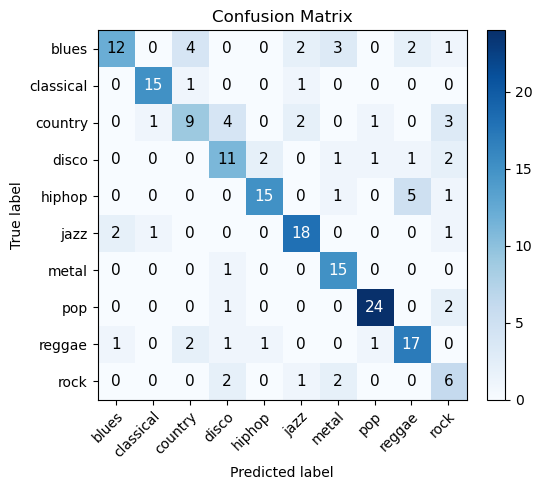

In [78]:
svmOvO.evaluate_accuracy(X_test, Y_test)
svmOvO.evaluate_models(X_test, Y_test)

true_labels = labels_encoding(Y_test, labels=class_names, pos_value=1, neg_value= 0)
pred_labels = labels_encoding(svmOvO(X_test), labels=class_names, pos_value=1, neg_value= 0)

confusion_matrix(true_labels, pred_labels, num_classes=10, class_names=class_names)

MLP model

In [79]:
# Convert string labels to integer class labels
Y_train_int = labels_to_numbers(Y_train)
Y_test_int = labels_to_numbers(Y_test)

# Then apply one-hot encoding
Y_train_encoded = one_hot_encoding(Y_train_int)
Y_test_encoded = one_hot_encoding(Y_test_int)

In [80]:
model = MLP(
    widths=config["layer_widths"],  # input size 40, two hidden layers, output size 10
    optimizer= AdamOptimizer(learning_rate= config["optimizer_learning_rate"]),
    activation=config["activation"],
    output_activation=config["output_activation"],
    loss=config["loss"]
)

In [81]:
metrics_dict = {
    "accuracy": accuracy,
    "loss" : cross_entropy,
}

metrics_history = model.fit(X_train, Y_train_encoded, num_epochs= config["epochs"], batch_size= config["batch_size"], compute_metrics=True, metrics_dict=metrics_dict)

In [82]:
print(f"Train accuracy: {metrics_history['accuracy'][-1]:.2f}% | "
      f"Test accuracy: {accuracy(model.decision_function(X_test), Y_test_encoded):.2f}%")

Train accuracy: 99.88% | Test accuracy: 74.50%


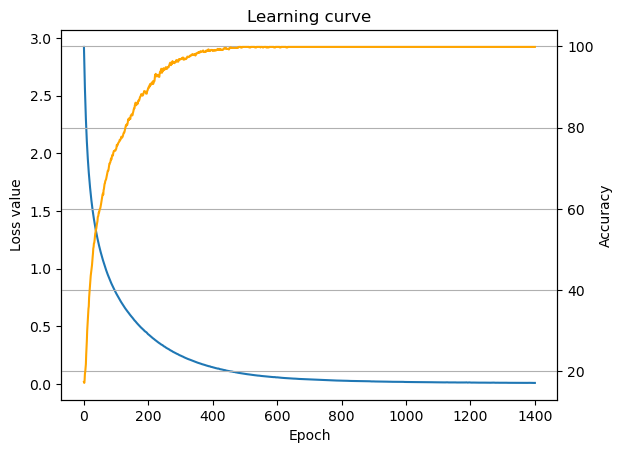

In [83]:
fig, ax = plt.subplots()

ax.plot(range(len(metrics_history['loss'])), metrics_history['loss'])
ax.set_ylabel('Loss value')

ax2 = ax.twinx()
ax2.plot(range(len(metrics_history['accuracy'])), metrics_history['accuracy'], color='orange')
ax2.set_ylabel('Accuracy')

ax.set_xlabel('Epoch')

plt.title('Learning curve')
plt.grid()

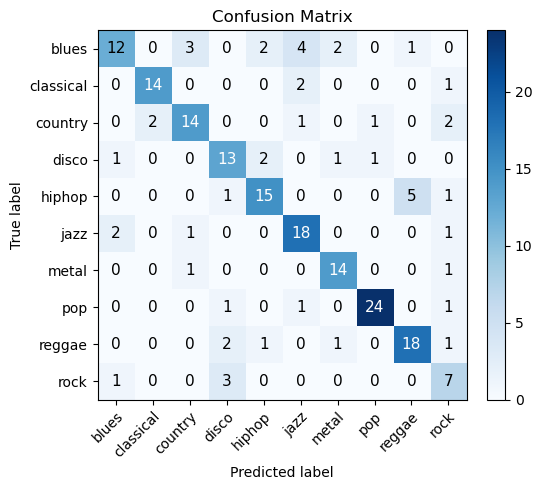

In [84]:
# Step 1: Convert true string labels to integer class indices
Y_test_int = labels_to_numbers(Y_test, class_names=class_names)

# Step 2: Get predicted class indices from model
Y_pred_int = model(X_test)  # returns integers, e.g., [2, 1, 5, ...]

# Step 3: Convert both to one-hot using your one_hot_encoding()
num_classes = len(class_names)
true_labels_onehot = one_hot_encoding(Y_test_int, num_classes)
pred_labels_onehot = one_hot_encoding(Y_pred_int, num_classes)

# Step 4: Plot confusion matrix using your function
confusion_matrix(
    y_true=true_labels_onehot,
    y_pred=pred_labels_onehot,
    num_classes=num_classes,
    plot=True,
    class_names=class_names
)


CNN on spectograms

In [91]:
transform = transforms.Compose([
    transforms.Resize((config_cnn["img_size"], config_cnn["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=config_cnn["normalize_mean"], std=config_cnn["normalize_std"])
])

# Load dataset from folders
dataset = datasets.ImageFolder(root=config_cnn["data_path"], transform=transform)


In [92]:
# Train/Validation split (80/20)
train_size = int(config_cnn["training_data_fraction"] * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=config_cnn["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config_cnn["batch_size"])

# Show class names
print("Classes:", dataset.classes)
print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))


Classes: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Number of training samples: 799
Number of validation samples: 200


In [93]:
class SimpleCNN(nn.Module):
    def __init__(self, config):
        super(SimpleCNN, self).__init__()
        img_size = config["img_size"]
        dropout = config["dropout"]
        num_classes = config["num_classes"]

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (img_size // 8) * (img_size // 8), 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


In [94]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(config_cnn).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(config_cnn["epochs"]):
    model.train()
    running_loss = 0.0
    correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

    accuracy = correct / len(train_dataset)
    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}, Accuracy: {accuracy:.4f}")


Epoch 1, Loss: 58.5454, Accuracy: 0.1101
Epoch 2, Loss: 57.0688, Accuracy: 0.1389
Epoch 3, Loss: 53.0594, Accuracy: 0.1815
Epoch 4, Loss: 51.6667, Accuracy: 0.2303
Epoch 5, Loss: 50.4473, Accuracy: 0.2340
Epoch 6, Loss: 49.7810, Accuracy: 0.2678
Epoch 7, Loss: 49.4899, Accuracy: 0.2578
Epoch 8, Loss: 48.5912, Accuracy: 0.2804
Epoch 9, Loss: 47.5375, Accuracy: 0.2966
Epoch 10, Loss: 47.5920, Accuracy: 0.3179
Epoch 11, Loss: 46.2724, Accuracy: 0.3267
Epoch 12, Loss: 45.3938, Accuracy: 0.3517
Epoch 13, Loss: 44.3955, Accuracy: 0.3542
Epoch 14, Loss: 43.6556, Accuracy: 0.3642
Epoch 15, Loss: 43.9641, Accuracy: 0.3504
Epoch 16, Loss: 42.4544, Accuracy: 0.3892
Epoch 17, Loss: 40.8724, Accuracy: 0.3905
Epoch 18, Loss: 40.1919, Accuracy: 0.4080
Epoch 19, Loss: 38.3895, Accuracy: 0.4518
Epoch 20, Loss: 38.7063, Accuracy: 0.4368


In [95]:
model.eval()
correct = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

val_accuracy = correct / len(val_dataset)
print(f"Validation accuracy: {val_accuracy:.4f}")


Validation accuracy: 0.3900


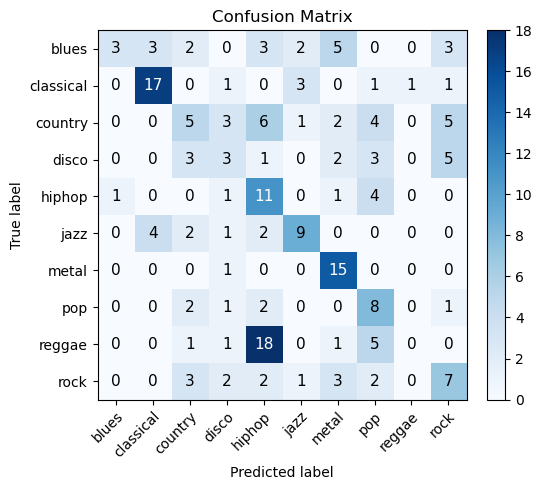

In [96]:
# Collect predictions and true labels on validation set
model.eval()
Y_true_int = []
Y_pred_int = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        Y_true_int.extend(labels.cpu().numpy())
        Y_pred_int.extend(preds.cpu().numpy())

# Convert to one-hot using your helper
num_classes = config_cnn["num_classes"]  # or len(dataset.classes) if not in config
true_labels_onehot = one_hot_encoding(Y_true_int, num_classes)
pred_labels_onehot = one_hot_encoding(Y_pred_int, num_classes)

# 📊 Plot confusion matrix using your custom function
confusion_matrix(
    y_true=true_labels_onehot,
    y_pred=pred_labels_onehot,
    num_classes=num_classes,
    plot=True,
    class_names=dataset.classes  # or class_names if you've defined it elsewhere
)